In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# building the vocabulary of chars and the mapping to/from integers
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [5]:
# building the dataset
block_size = 3 # context length : how many characters we take to predict the next one
X,y = [],[]
for w in words[:5]:

    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        y.append(ix)
        print(''.join(itos[i] for i in context),'->',itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
y = torch.tensor(y)


emma
... -> e
..e -> m
.em -> m
emm -> a
mma -> .
olivia
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .
ava
... -> a
..a -> v
.av -> a
ava -> .
isabella
... -> i
..i -> s
.is -> a
isa -> b
sab -> e
abe -> l
bel -> l
ell -> a
lla -> .
sophia
... -> s
..s -> o
.so -> p
sop -> h
oph -> i
phi -> a
hia -> .


In [6]:
X.shape

torch.Size([32, 3])

In [7]:
y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [8]:
C = torch.randn((27,2))

In [9]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [10]:
emb[:,0,:][2]

tensor([-0.5864,  1.1013])

In [11]:
emb[:,1,:][2]

tensor([-1.1883, -0.0717])

In [12]:
emb[:,2,:][2]

tensor([ 0.6693, -1.5404])

In [13]:
# inefficient creates new memory
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],dim=1).shape

torch.Size([32, 6])

In [14]:
#  a better way to do this would be to use unbind
torch.cat(torch.unbind(emb,dim=1),1).shape

torch.Size([32, 6])

In [15]:
emb.view(32,6)

tensor([[-0.5864,  1.1013, -0.5864,  1.1013, -0.5864,  1.1013],
        [-0.5864,  1.1013, -0.5864,  1.1013, -1.1883, -0.0717],
        [-0.5864,  1.1013, -1.1883, -0.0717,  0.6693, -1.5404],
        [-1.1883, -0.0717,  0.6693, -1.5404,  0.6693, -1.5404],
        [ 0.6693, -1.5404,  0.6693, -1.5404, -1.6952, -0.7932],
        [-0.5864,  1.1013, -0.5864,  1.1013, -0.5864,  1.1013],
        [-0.5864,  1.1013, -0.5864,  1.1013,  0.5153,  0.1130],
        [-0.5864,  1.1013,  0.5153,  0.1130,  0.0832, -1.0090],
        [ 0.5153,  0.1130,  0.0832, -1.0090,  1.1480, -1.7891],
        [ 0.0832, -1.0090,  1.1480, -1.7891,  0.0404,  1.1928],
        [ 1.1480, -1.7891,  0.0404,  1.1928,  1.1480, -1.7891],
        [ 0.0404,  1.1928,  1.1480, -1.7891, -1.6952, -0.7932],
        [-0.5864,  1.1013, -0.5864,  1.1013, -0.5864,  1.1013],
        [-0.5864,  1.1013, -0.5864,  1.1013, -1.6952, -0.7932],
        [-0.5864,  1.1013, -1.6952, -0.7932,  0.0404,  1.1928],
        [-1.6952, -0.7932,  0.0404,  1.1

In [16]:
w1 = torch.randn((6,100))
b1 = torch.randn(100)

In [17]:
# hidden layer with 100 neuron
h = torch.tanh(emb.view(-1,6) @ w1 + b1)

In [18]:
w2 = torch.randn((100,27))
b2 = torch.randn(27)

In [19]:
logits = h @ w2 + b2

In [20]:
counts = logits.exp()
counts[0].sum()

tensor(20510414.)

In [21]:
# summing along columns (1) When we  sum along a column (dim=1) in a 2D tensor, it means we are summing across all columns in each row—so we get a single value per row.
# sum(1, keepdim=True) sums along axis 1 but keeps the result as a column vector.
probs = counts / counts.sum(1,keepdim=True)

In [22]:
loss = -probs[torch.arange(32),y].log().mean()
loss

tensor(15.8288)

In [23]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [24]:
# building dataset
X, y = [], []
block_size = 3
for w in words:
    context = [0]* block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
y = torch.tensor(y)
X.shape,y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [25]:
def build_dataset(words):
    block_size = 3
    X, y = [], []
    for w in words:
        context = [0]* block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    y = torch.tensor(y)
    print(X.shape,y.shape)
    return X,y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr,ytr = build_dataset(words[:n1])
Xval,yval = build_dataset(words[n1:n2])
Xte,yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [26]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,20),generator=g)
w1 = torch.randn((60,300),generator=g)
b1 = torch.randn(300,generator=g)
w2 = torch.randn((300,27),generator=g)
b2 = torch.randn(27,generator=g)
params = [C,w1,b1,w2,b2]

In [27]:
sum(p.nelement() for p in params)

26967

In [28]:
for p in params:
    p.requires_grad = True

In [29]:
lri = []
lossi = []
stepi = []

In [30]:

for i in range(200000):
    # mini batch
    ix = torch.randint(0,Xtr.shape[0],(32,))

    emb = C[Xtr[ix]]
    # forward pass
    h = torch.tanh(emb.view(-1,60) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits,ytr[ix])
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 10000 else 0.01
    # lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)
    #update
    for p in params:
        p.data += -lr * p.grad
print(loss.item())

2.029359817504883


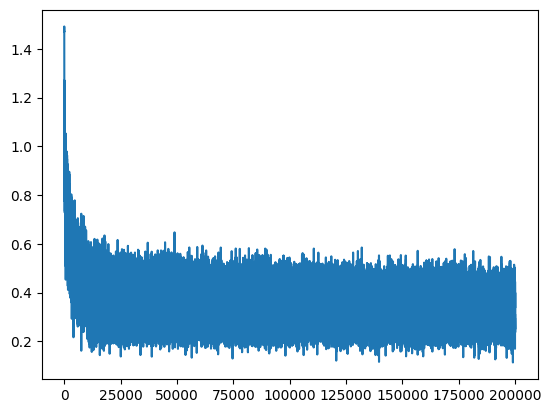

In [31]:
plt.plot(stepi,lossi)

In [32]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,60) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits,ytr)
loss

tensor(2.1621, grad_fn=<NllLossBackward0>)

In [33]:
emb = C[Xval]
h = torch.tanh(emb.view(-1,60) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits,yval)
loss

tensor(2.2494, grad_fn=<NllLossBackward0>)

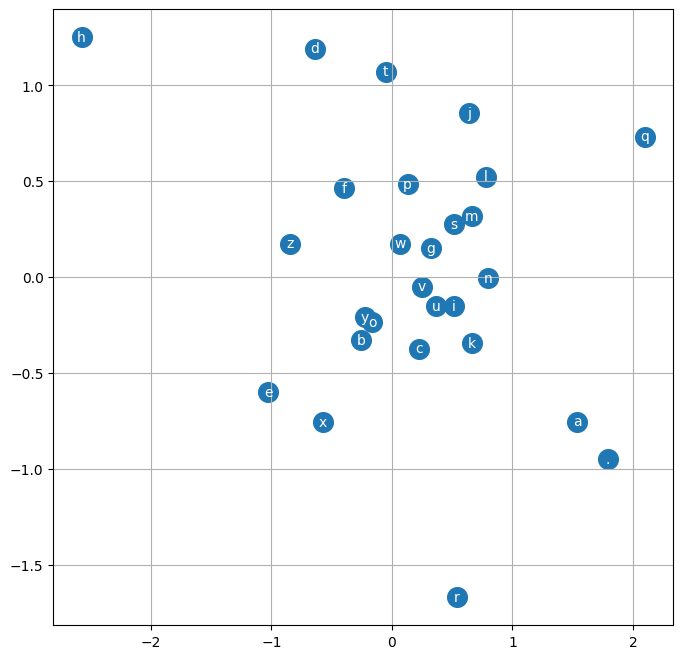

In [35]:
# visualizing the trained embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha="center",va="center",c="white")
plt.grid("minor")


In [36]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits,dim=-1)
        ix = torch.multinomial(probs,1,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

texchariah.
makilah.
tyreev.
jimitta.
nylandrika.
da.
staryaella.
hayiotzxbie.
jen.
kau.
keytheo.
kaley.
masade.
enka.
nyn.
ryton.
mhinite.
viah.
asu.
jad.
